# Snipping examples

## Background

Snipping is the act of extraction rectangular "snippets" from a dataset containing pore-c interactions in the form of pixels. For example, we might have a file containing two-way interactions (similar to conventional Hi-C) in the form of a matrix of genomic bins, that encode the interaction frequency of these pixels. We might want to extract the neighborhood of TAD-boundaries form this file, specifically, neighborhoods centered at TAD-boundaries that stretch 1MB upstream and downstream. The results of this extraction is a 3-dimensional matrix, where the first two dimensions encode the relative genomic offset and the third dimension encodes the particular examples, here TAD-boundaries.

## Average representation of snippets

Snipping is often the first step of an anlysis pipeline, where the extraction of snippets is followed by reducing them along the example dimension to obtain an average representation of a particular genomic neighborhood.

## Higher-order contacts and snipping

If we want to extract snippets from a higher-order contact file, things get a little more complicated than for two-way contacts. Specifically, we are often interested in obtaining a two-dimensional representation of a certain high-dimensional snippet to enable visualization. To do this, we need to define different ways of snipping from a high-dimensional file. For example, we might want to know, which two-dimensional contacts are associated with a set of third coordinates, like TAD-boundaries. Or we might want to know which genomic positions are associated with a two-dimensional query. To account for this, spoc implements different "snipping strategies" that encapsulate the different ways we might want to query a high-dimensional contact file.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

## Snipper class
The snipper class is spoc's central interface to access snipping functionality. It can be used with different snipping strategies to extract snippets. The idea is that a snipper can hold different snipping strategies that can be deployed to achieve the desired result.

In [3]:
from spoc.snipping import Snipper

## Snipping strategies and snipping vlaues

### Snipping strategies

Snipping strategies are specific ways of snipping higher order contacts. For example, the `Triplet1DSnippingStrategy` implements snipping 2D pieces from triplets based on a set of 1d-coordinates. This can be used to ask questions like:

- Do sister chromatids form internal loops, when they contact each other?

The idea is that a specific snipping strategy encapsulates all information of extracting snippets such as the size of the snippets, potential offsets, values etc. The constructor of a specific snipping strategy is specific to that strategy, but the snipping implementation has a unified strategy to allow composing different strategies in a snipper class.

### Snipping values

Usually, the values that are extracted from a target file can be either ICCF (iteratively corrected contact frequencies), or observed-over-expected values. The latter represents the ratio of the actually observed contacts and the expected contacts for randomly chosen genomic regions.

In [5]:
from spoc.snipping.snipping_strategies import Triplet1DSnippingStrategy, SnippingValues

In [27]:
snip_strat_center = Triplet1DSnippingStrategy(bin_size=100_000,
                                              half_window_size=2_000_000,
                                              snipping_value=SnippingValues.ICCF)

In [28]:
snipper = Snipper([snip_strat_center])

- Here the snipper is instantiated with a single snipping strategy, that snips ICCF values from the center of a set of regions

In [29]:
tad_boundaries = pd.read_csv("../playground/tad_boundaries.csv")

- TADs as target regions are loaded

In [30]:
result = snipper.snip("../playground/test.parquet", tad_boundaries, threads=40)

- Snipper is used to snip ICCF values around TAD-boundaries with a 1Mbp half-window size

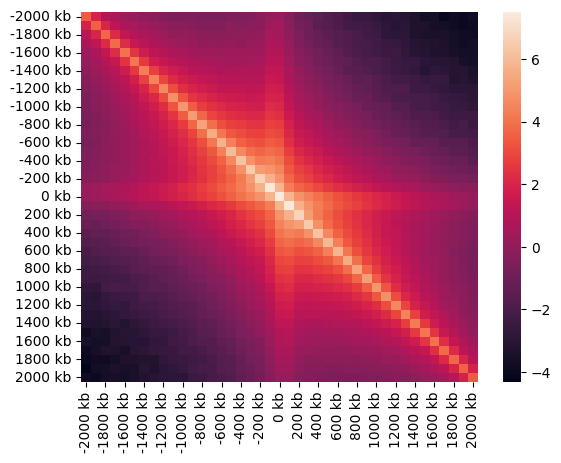

In [31]:
f, ax = plt.subplots()
sbn.heatmap(np.log2(result[0]))
plt.show()

## Combining snipping strategies
Multiple snipping strategies can be used and dispatched together.

### Snip ICCF and Obs/Exp together

In [38]:
snip_strat_center_obs_exp = Triplet1DSnippingStrategy(bin_size=100_000,
                                              half_window_size=2_000_000,
                                              snipping_value=SnippingValues.OBSEXP)                                            

In [39]:
snipper = Snipper([snip_strat_center, snip_strat_center_obs_exp])

In [40]:
result = snipper.snip("../playground/test.parquet", tad_boundaries, threads=40)

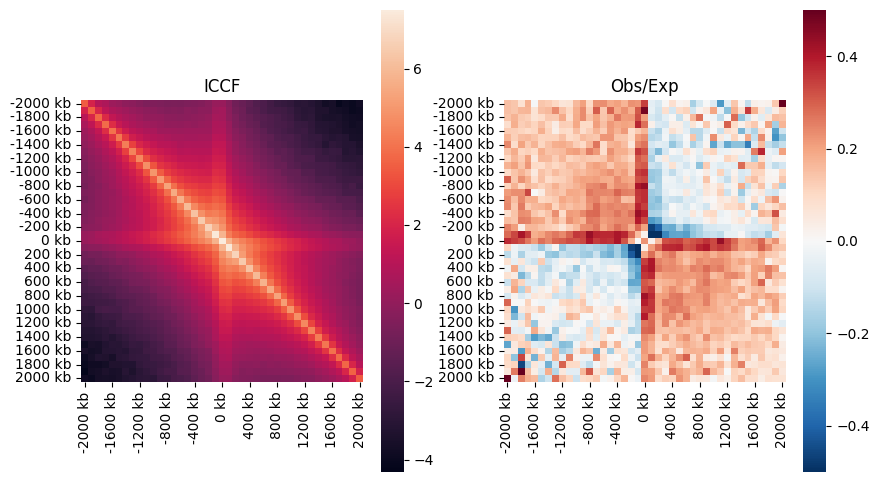

In [45]:
f, ax = plt.subplots(1, 2)
sbn.heatmap(np.log2(result[0]), ax=ax[0], square=True)
ax[0].set_title("ICCF")x
sbn.heatmap(np.log2(result[1]), ax=ax[1], cmap="RdBu_r", vmin=-0.5, vmax=0.5, square=True)
ax[1].set_title("Obs/Exp")
f.set_size_inches(10, 6)
plt.show()

Generate triplet strategies with different offsets

In [50]:
offset_strategies = [
    Triplet1DSnippingStrategy(bin_size=100_000,
                                              half_window_size=2_000_000,
                                              snipping_value=SnippingValues.ICCF,
                                              relative_offset=offset)
    for offset in np.arange(-1_000_000, 1_000_001, 500_000)
]

In [52]:
snipper = Snipper(offset_strategies)

In [53]:
result = snipper.snip("../playground/test.parquet", tad_boundaries, threads=40)

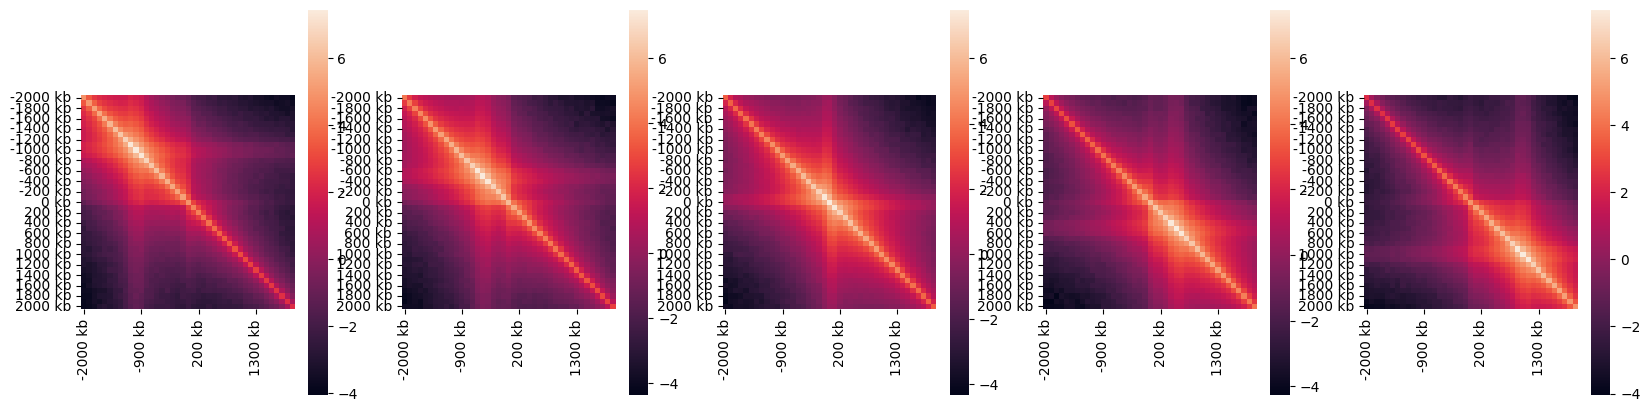

In [57]:
f, ax = plt.subplots(1, len(result))
for index, array in enumerate(result):
    sbn.heatmap(np.log2(result[index]), ax=ax[index], square=True)
f.set_size_inches(20, 5)
plt.show()